In [1]:

from __future__ import division

In [2]:
%matplotlib inline

https://github.com/juhuntenburg/brainsurfacescripts

In [3]:
import gdist
import numpy as np
import pandas as pd
from pqdict import PQDict
#from mayavi import mlab
import seaborn as sns
from scipy import stats as stats
import scipy as sp
import matplotlib.pyplot as plt
from vtk_rw import read_vtk, write_vtk
from graphs import graph_from_mesh, dijkstra, shortest_path, sorted_path
from plotting import plot_surf_stat_map, plot_surf_label
from jensen_shannon import jensenshannon
from scipy.signal import argrelmax

/scr/ilz1/cbspython_surf/surfenv/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

In [5]:
def prob_mass_function(data, bins='auto', range_min=None, range_max=None):
    
    import numpy as np
    data = data.flatten()
    
    if range_min is None:
        range_min = np.nanmin(data)
    if range_max is None:
        range_max = np.nanmax(data)
        
    if bins == 'auto':
        bins = data.shape[0]/5
        
    p_mass, x_values = np.histogram(data, bins=bins, range=(range_min, range_max))
    p_mass = p_mass / data.shape[0]
    x_values = x_values[:-1] + (x_values[1] - x_values[0])/2
    
    return p_mass, x_values




def jensenshannon(data, range_min=None, range_max=None, base=2, weights=None):
    
    import numpy as np
    import scipy as sp
    
    if range_min is None:
        data_mins = [np.nanmin(m) for m in data]
        range_min = data_mins[np.argmin(data_mins)]
    
    if range_max is None:
        data_maxs = [np.nanmax(n) for n in data]
        range_max = data_maxs[np.argmax(data_maxs)]
    
    data_shapes = [k.shape[0] for k in data]
    bins = int(np.round(data_shapes[np.argmin(data_shapes)]/5))
    p_mass = np.zeros((len(data), bins))
    
    combined_data = []
    for i in range(len(data)):
        p_mass[i], _ = prob_mass_function(data[i], bins, range_min, range_max)
        combined_data += list(data[i])
        
    p_mass_combined, _ = prob_mass_function(np.asarray(combined_data), bins, range_min, range_max)
    
    shannon_entropy = [sp.stats.entropy(p_mass[j], base=base) for j in range(p_mass.shape[0])]
    shared_shannon_entropy = sp.stats.entropy(p_mass_combined, base=base)
    
    if weights is None:
        weights = 1/len(data)
        
    shannon_entropy = np.asarray(shannon_entropy) * np.asarray(weights)
    
    jsdivergence = shared_shannon_entropy - np.sum(shannon_entropy)
    
    jsdistance = np.sqrt(jsdivergence)
    
    return jsdivergence, jsdistance

In [6]:
def make_eta_cmap(c):
    cmap= np.asarray(sns.diverging_palette(15, 240, n=c, center='dark'))
    cmap = np.concatenate((np.array([[0.8,0.8,0.8,1]]), cmap), axis=0)
    #cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

### Data

In [7]:
mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
sulc_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_sulc.npy'
embed_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/smooth_3/mask_025_5/rh_embed_10.npy'
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/avg_rh_profiles.npy'
path_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/rh_path%i.1D.roi'

In [8]:
v,f,d=read_vtk(mesh_file)
vertices = v.astype(np.float64)
faces = f.astype(np.int32)
sulc = np.load(sulc_file)
profiles = np.load(t1_file)
embed = np.load(embed_file)

In [9]:
G=graph_from_mesh(vertices, faces, edge_length=True)

### Path and windows

In [10]:
num_path=3
radius=4
halfwidth=2 # combined window size will be 2*halfwidth single windows
overlap=1 # in single windows

In [11]:
out_dir = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/plots/'
path_plot = out_dir+'path%i_rad%i_hw%i_overlap%i_surf.png'%(num_path, radius, halfwidth, overlap)
windows_plot = out_dir+'path%i_rad%i_hw%i_overlap%i_windows.png'%(num_path, radius, halfwidth, overlap)
windows_plot_small = out_dir+'path%i_rad%i_hw%i_overlap%i_windows_small.png'%(num_path, radius, halfwidth, overlap)
coeff_single_plot = out_dir+'path%i_rad%i_hw%i_overlap%i_coeff_single.png'%(num_path, radius, halfwidth, overlap)
coeff_combi_plot = out_dir+'path%i_rad%i_hw%i_overlap%i_coeff_combi.png'%(num_path, radius, halfwidth, overlap)
jsd_plot = out_dir+'path%i_rad%i_hw%i_overlap%i_jsd.png'%(num_path, radius, halfwidth, overlap)
border_plot = out_dir+'path%i_rad%i_hw%i_overlap%i_borders_%s.png'
border_plot_2 = out_dir+'path%i_rad%i_hw%i_overlap%i_borders_%s_2.png'

In [12]:
path = sorted_path(G, np.loadtxt(path_file%num_path, dtype='int64')[:,0])

In [13]:
# for each vertex show only those vertices in the sparse matrix, that have a distance < radius
# for these give the precise distance
inradius_matrix=gdist.local_gdist_matrix(vertices, faces, max_distance=radius)

In [14]:
# get only the vertices that are in a distance < radius to any node in path
inradius_path=[]
for pnode in path:
    inradius_path=list(np.unique(inradius_matrix[:,path].indices))

In [15]:
# make an array with the radius neighbours in columns and the path nodes in rows
path_x_neighbours=np.zeros((len(inradius_path), len(path)))
for pnode in range(len(path)):
    path_x_neighbours[:,pnode]=np.reshape(inradius_matrix[inradius_path,path[pnode]].toarray(),
                                          (len(inradius_path),))
path_x_neighbours[path_x_neighbours==0]=np.nan

In [16]:
# for each vertex in this list, find the node on path it is closest to
path_x_neighbours_min=np.zeros((len(inradius_path),1))
for nnode in range(len(inradius_path)):
    path_x_neighbours_min[nnode]=np.nanargmin(path_x_neighbours[nnode,:])

In [17]:
#for each node on the path, extract those neighbour nodes, that fall into its window
windows=[]
for pnode in range(len(path)):
    window=[path[pnode]]
    indices = [i for i, x in enumerate(list(path_x_neighbours_min)) if x == pnode]
    [window.append(inradius_path[y]) for y in indices]
    windows.append(window)

In [18]:
# combine single windows for sliding, some nodes at the end of the path might be dropped to ensure equal sized windows
combined_windows=[]
for window in np.arange(start=halfwidth, stop=len(windows)-halfwidth, step=2*halfwidth-overlap):
    combined_window=[]
    for k in range(window-halfwidth,window+halfwidth):
        combined_window+=windows[k]
    combined_windows.append(combined_window)

### Sample profiles in windows

In [19]:
profiles = profiles[:,3:8]

In [20]:
# sample t1 per window, calc mean profile and sdv
profile_windows=[]
profile_avg=[]
profile_sdv=[]
for window in combined_windows:
    profile_windows.append(profiles[window])
    profile_avg.append(np.mean(profiles[window], axis=0))
    profile_sdv.append(np.std(profiles[window], axis=0))

In [21]:
# calculate chebychev coefficients for all the profiles in the windows, as well as mean chebychev per window
cheb_windows=[]
cheb_avg=[]
for window in combined_windows:
    coeff, poly = chebapprox(profiles[window], degree=4)
    cheb_windows.append(coeff)
    cheb_avg.append(np.mean(coeff, axis=0))

In [22]:
# calculate jensen shannon divergence between windows regarding average, profiles, chebychev coefficients
t1_avg_jsdis = np.zeros((len(profile_windows)-1,))
t1_avg_jsdiv = np.zeros((len(profile_windows)-1,))
profile_jsdis = np.zeros((len(profile_windows)-1,profile_windows[0].shape[1]))
cheb_jsdis = np.zeros((len(cheb_windows)-1,cheb_windows[0].shape[1]))
                     
for j in range(len(profile_windows)-1):
    t1_avg_jsdiv[j], t1_avg_jsdis[j] = jensenshannon([np.mean(profile_windows[j], axis=1), 
                                        np.mean(profile_windows[j+1], axis=1)], 
                                       range_min=1500, range_max=2500)
    
    for p in range(profile_windows[j].shape[1]):
        _, profile_jsdis[j][p] = jensenshannon([profile_windows[j][:,p], profile_windows[j+1][:,p]], 
                                               range_min=1500, range_max=2500)
                     
    for c in range(cheb_windows[j].shape[1]):
        _, cheb_jsdis[j][c] = jensenshannon([cheb_windows[j][:,c], cheb_windows[j+1][:,c]])

### Plotting

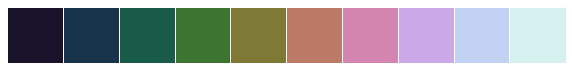

In [23]:
colors = sns.color_palette('cubehelix', 10)
sns.palplot(colors)

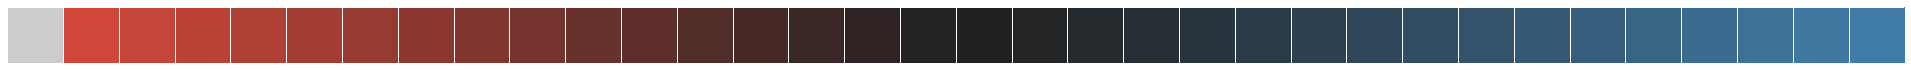

In [24]:
eta_cmap, eta_cmap_255 = make_eta_cmap(len(profile_avg))
sns.palplot(eta_cmap)

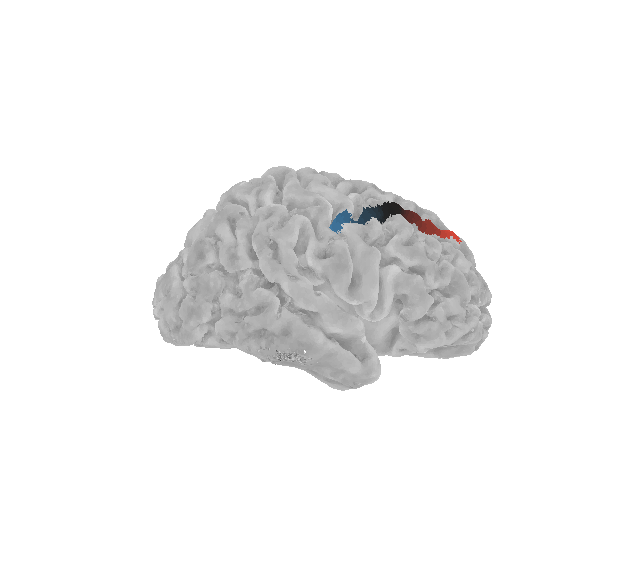

In [25]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(combined_windows), cpal=eta_cmap[1:], bg_map=sulc, 
                        elev=180,azim=0, figsize=(11,10), darkness=0.8)
plot.savefig(path_plot)

In [61]:
sns.set_style('darkgrid')

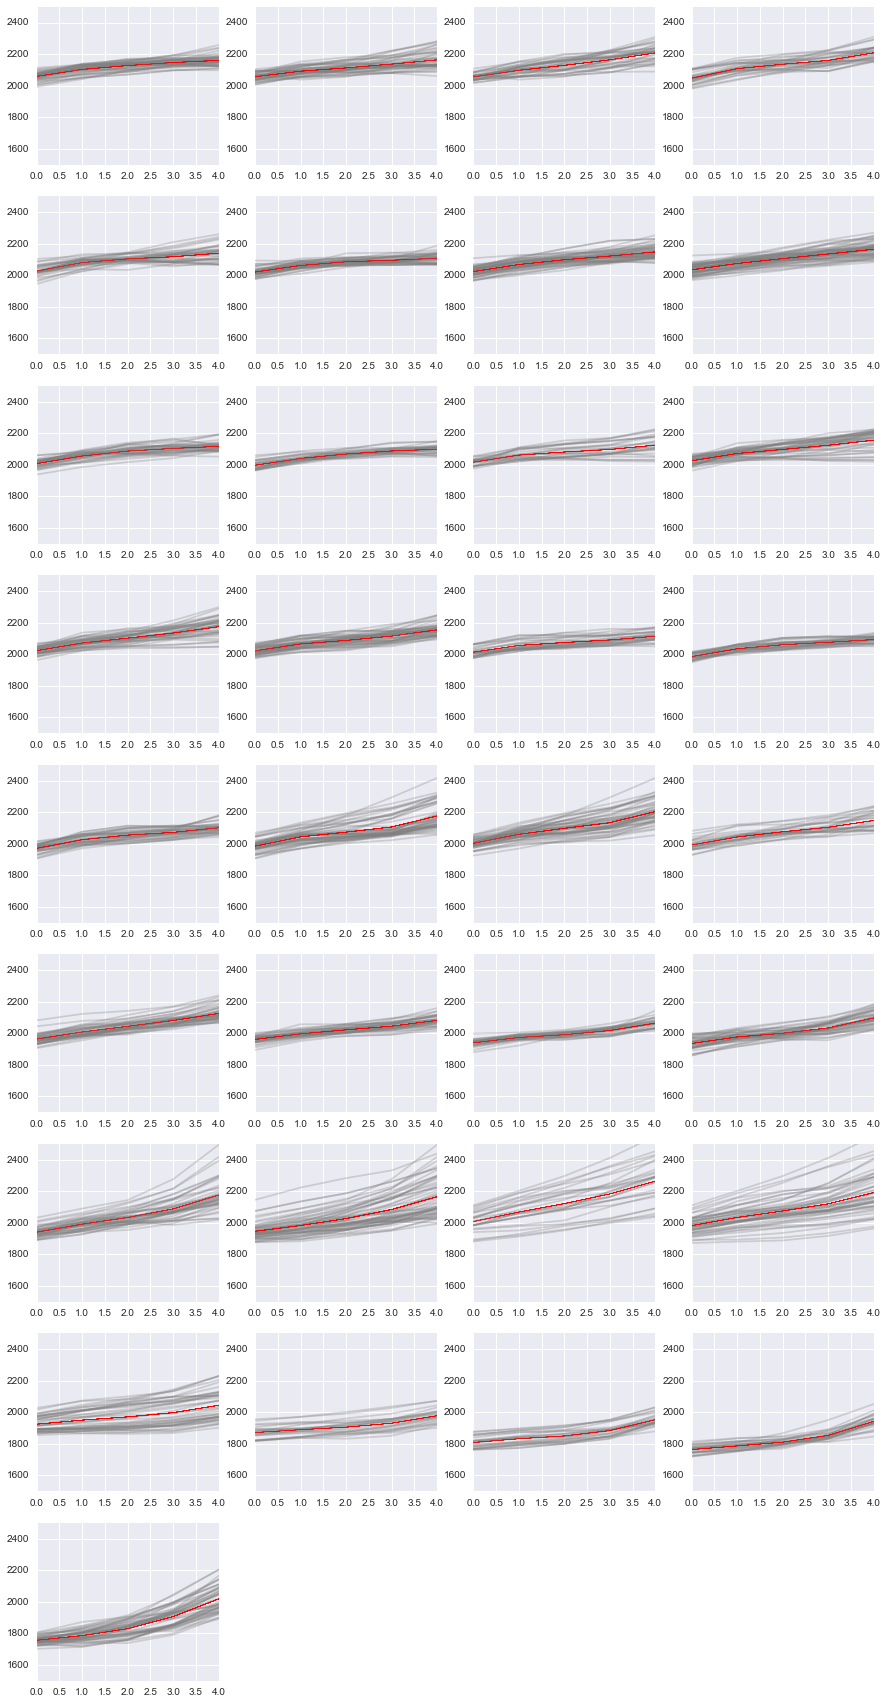

In [62]:
fig = plt.figure(figsize=(15,30))
for i in range(len(profile_avg)):
    ax = fig.add_subplot(int(np.ceil(len(profile_avg)/4)),4,i+1)
    for pro in range(len(profile_windows[i])):
        plt.plot(profile_windows[i][pro],color='gray', alpha=0.3)
        plt.plot(profile_avg[i], color='red', linewidth=0.2)
    ax.set_ylim([1500,2500])
fig.savefig(windows_plot)

/scr/ilz1/cbspython_surf/surfenv/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


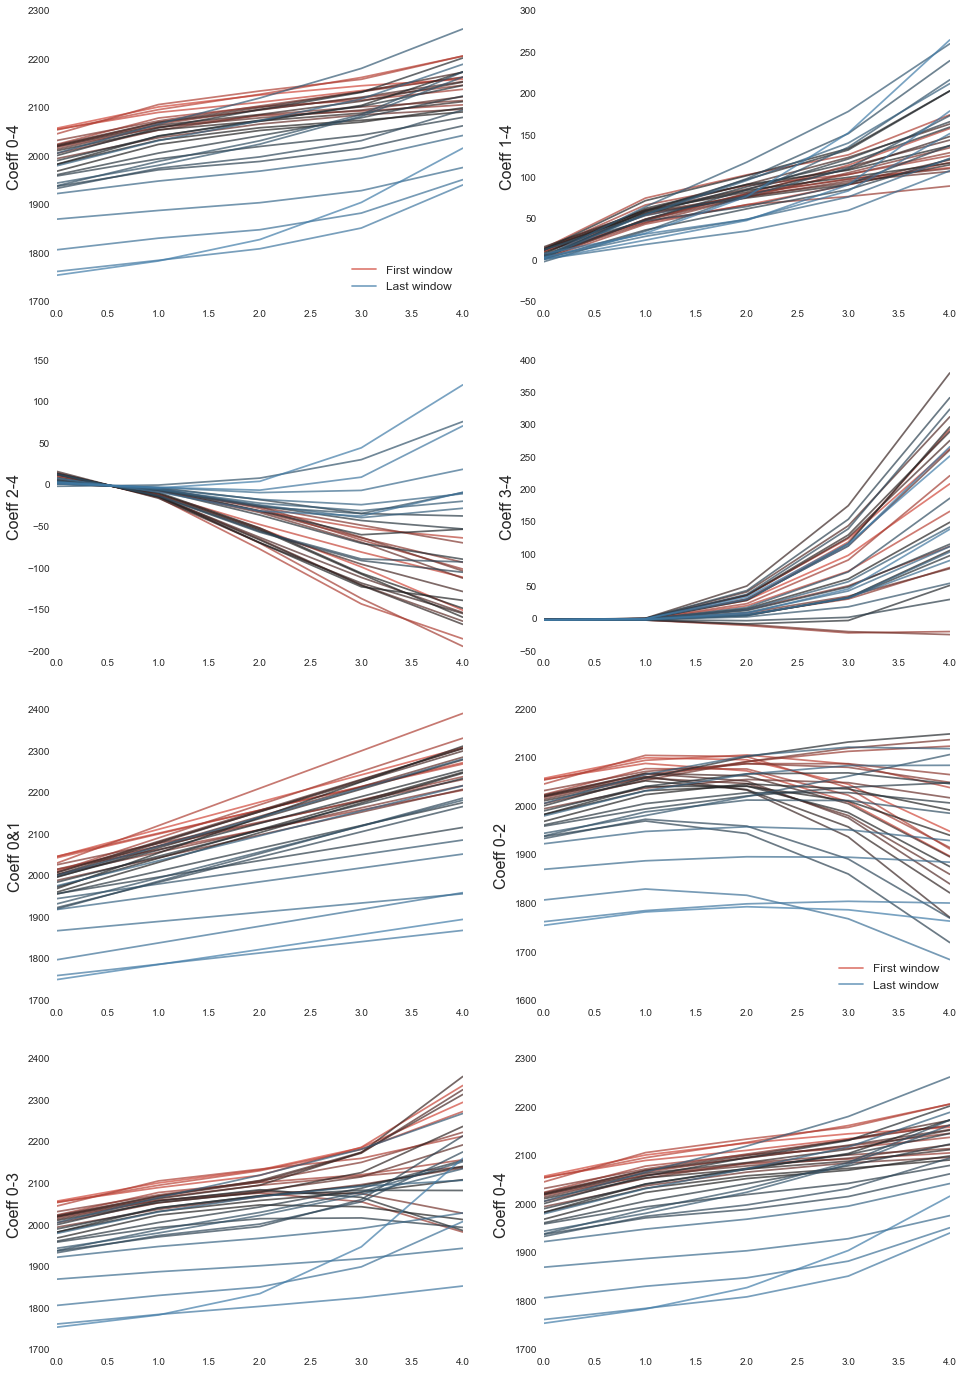

In [28]:
sns.set_style('white')
alpha=0.7
x = np.arange(len(cheb_windows[0][0]))
fig = plt.figure(figsize=(16,24))

fig.add_subplot(421)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0], cheb_avg[w][1], cheb_avg[w][2],
                                                           cheb_avg[w][3], cheb_avg[w][4]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 0-4', fontsize=16)


fig.add_subplot(422)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0, cheb_avg[w][1], cheb_avg[w][2],
                                                           cheb_avg[w][3], cheb_avg[w][4]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    #if i==0:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    #elif i==len(cheb_avg)-1:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    #else:
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 1-4', fontsize=16)


fig.add_subplot(423)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0, 0, cheb_avg[w][2],
                                                           cheb_avg[w][3], cheb_avg[w][4]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    #if i==0:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    #elif i==len(cheb_avg)-1:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    #else:
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 2-4', fontsize=16)



fig.add_subplot(424)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0, 0, 0,
                                                           cheb_avg[w][3], cheb_avg[w][4]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    #if i==0:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    #elif i==len(cheb_avg)-1:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    #else:
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 3-4', fontsize=16)



fig.add_subplot(425)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0], cheb_avg[w][1]])
    
for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    
    #if i==0:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    #elif i==len(cheb_avg)-1:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    #else:
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 0&1', fontsize=16)



fig.add_subplot(426)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0], cheb_avg[w][1], cheb_avg[w][2]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 0-2', fontsize=16)



fig.add_subplot(427)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0], cheb_avg[w][1], cheb_avg[w][2],
                                                           cheb_avg[w][3]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    #if i==0:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    #elif i==len(cheb_avg)-1:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    #else:
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 0-3', fontsize=16)

fig.add_subplot(428)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0], cheb_avg[w][1], cheb_avg[w][2],
                                                           cheb_avg[w][3], cheb_avg[w][4]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    #if i==0:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    #elif i==len(cheb_avg)-1:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    #else:
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 0-4', fontsize=16)


sns.despine(left=True, bottom=True)

fig.savefig(coeff_single_plot)

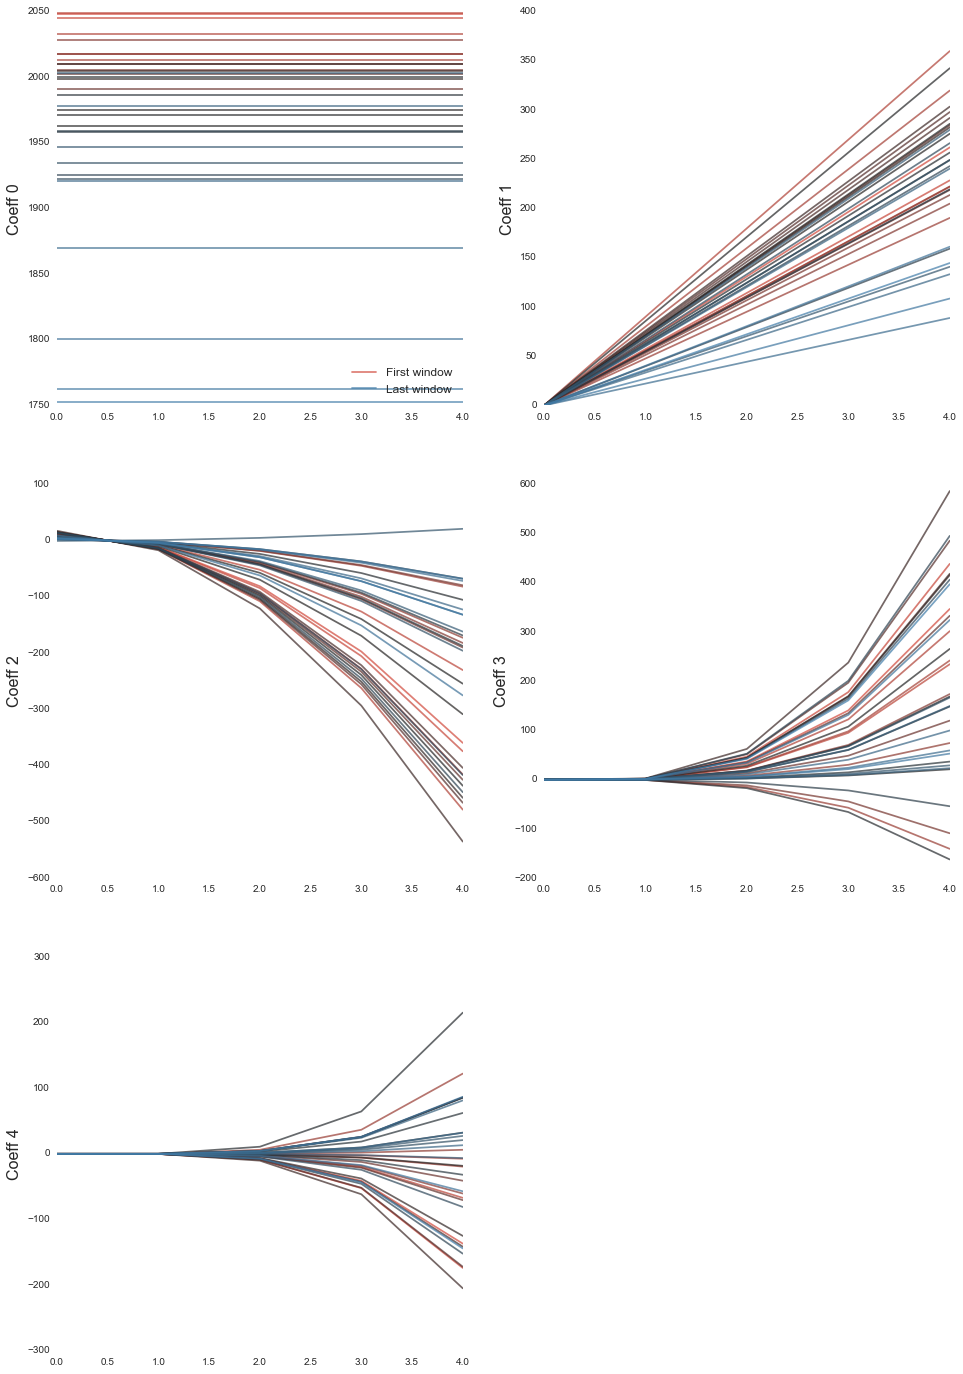

In [29]:
alpha=0.7
x = np.arange(len(cheb_windows[0][0]))
fig = plt.figure(figsize=(16,24))

fig.add_subplot(321)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0]])
    
for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 0', fontsize=16)



fig.add_subplot(322)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,cheb_avg[w][1]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    #if i==0:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    #elif i==len(cheb_avg)-1:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    #else:
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 1', fontsize=16)



fig.add_subplot(323)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,cheb_avg[w][2]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    #if i==0:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    #elif i==len(cheb_avg)-1:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    #else:
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 2', fontsize=16)



fig.add_subplot(324)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,0,
                                                           cheb_avg[w][3]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    #if i==0:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    #elif i==len(cheb_avg)-1:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    #else:
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 3', fontsize=16)




fig.add_subplot(325)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,0,0,cheb_avg[w][4]])

for i in range(cheb_avg_plot.shape[0]):
    r=eta_cmap[i+1][0]
    g=eta_cmap[i+1][1]
    b=eta_cmap[i+1][2]
    #if i==0:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='First window', alpha=alpha)
    #elif i==len(cheb_avg)-1:
    #    plt.plot(cheb_avg_plot[i], color=(r,g,b),label='Last window', alpha=alpha)
    #else:
    plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=12)
plt.ylabel('Coeff 4', fontsize=16)

sns.despine(left=True, bottom=True)

fig.savefig(coeff_combi_plot)

#### Jensen shannon divergence between windows

In [30]:
five_colors = sns.color_palette('cubehelix',6)

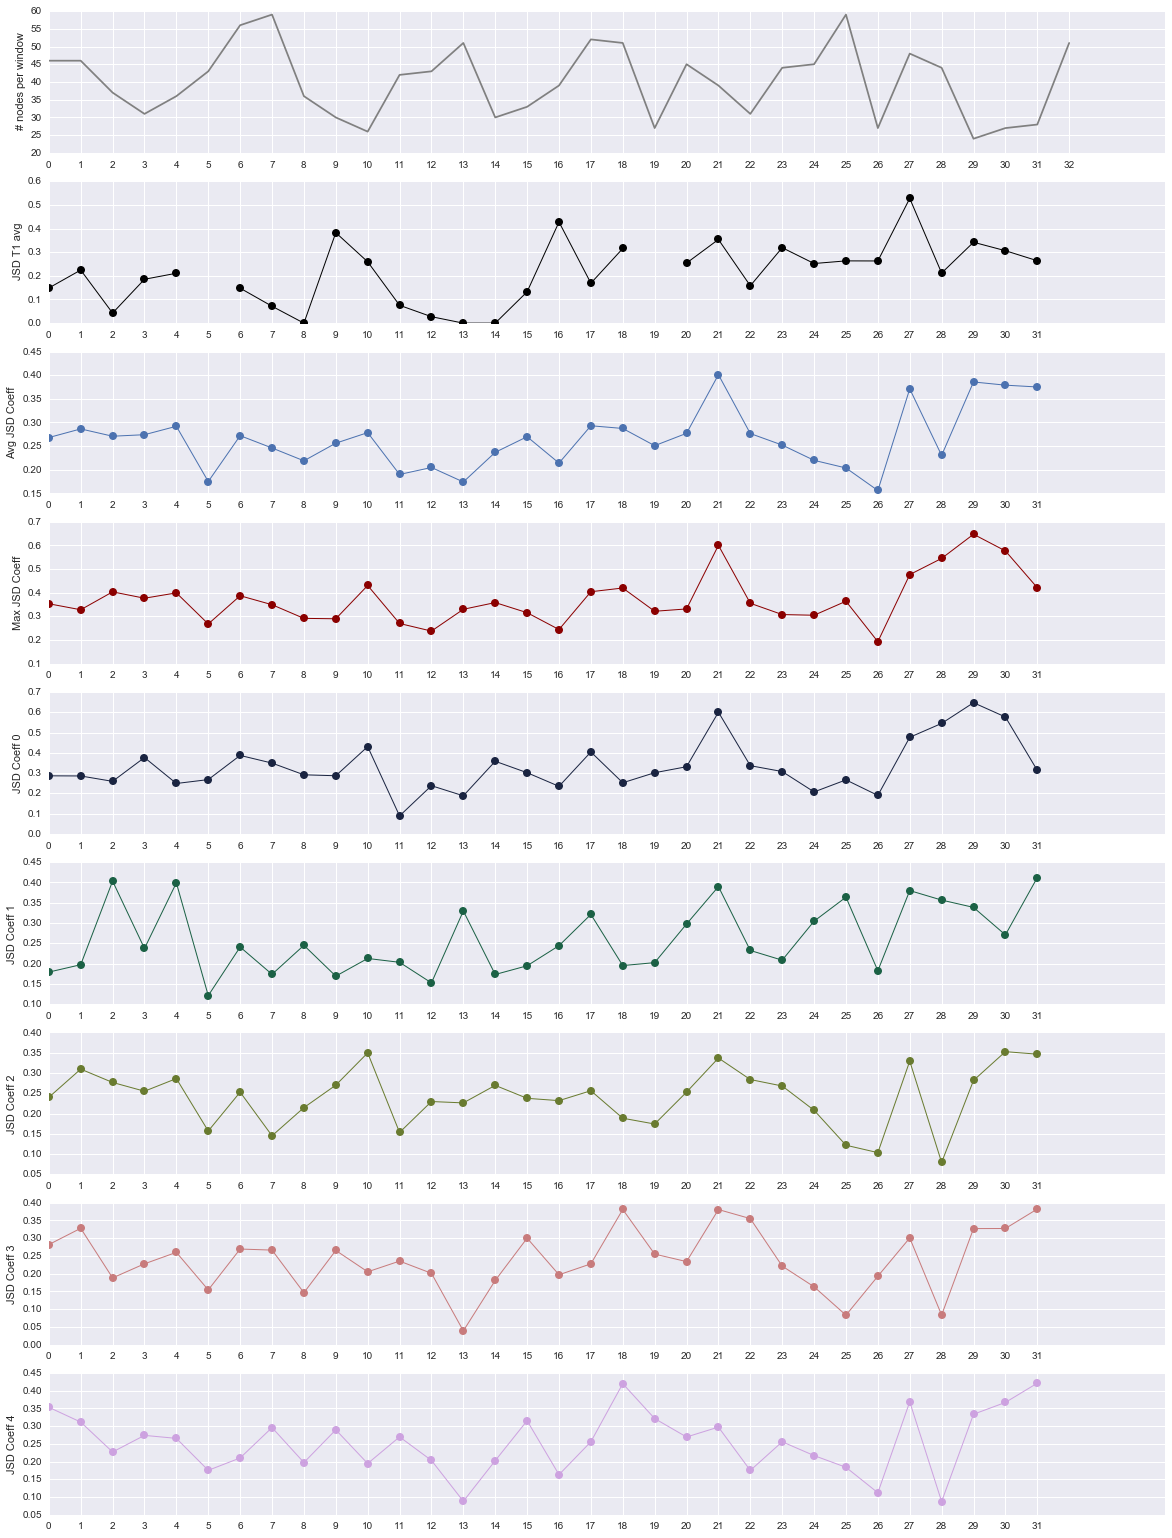

In [31]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(20,30))

wsize=[]
for window in combined_windows:
    wsize.append(len(window))
fig.add_subplot(10,1,1)
plt.plot(wsize, color='gray')
#plt.xlim([0, len(wsize)-1])
plt.xticks(np.arange(len(wsize)));
plt.ylabel(' # nodes per window')

fig.add_subplot(10,1,2)
plt.plot(t1_avg_jsdis, marker='o', markersize=8,linewidth=1, color='black')
plt.xticks(np.arange(t1_avg_jsdis.shape[0]));
plt.ylabel(' JSD T1 avg')

fig.add_subplot(10,1,3)
plt.plot(np.nanmean(cheb_jsdis, axis=1), marker='o', markersize=8,linewidth=1)
plt.xticks(np.arange(t1_avg_jsdis.shape[0]));
plt.ylabel('Avg JSD Coeff')

fig.add_subplot(10,1,4)
plt.plot(np.nanmax(cheb_jsdis, axis=1), marker='o', markersize=8,linewidth=1, color='darkred')
plt.xticks(np.arange(t1_avg_jsdis.shape[0]));
plt.ylabel('Max JSD Coeff')


for c in range(cheb_jsdis.shape[1]):
    fig.add_subplot(10,1,(c+5))
    plt.plot(cheb_jsdis[:,c], label=str(c), color=five_colors[c], marker='o', markersize=8, linewidth=1)
    plt.xticks(np.arange(t1_avg_jsdis.shape[0]));
    plt.ylabel('JSD Coeff %i'%c)

fig.savefig(jsd_plot)

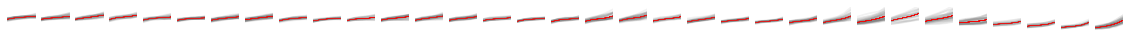

In [63]:
sns.set_style('white')
fig = plt.figure(figsize=(20,.5))
for i in range(len(profile_avg)):
    ax = fig.add_subplot(1,int(np.ceil(len(profile_avg))),i+1)
    for pro in range(len(profile_windows[i])):
        plt.plot(profile_windows[i][pro],color='gray', alpha=0.1)
        plt.plot(profile_avg[i], color='red', linewidth=0.2)
        plt.xticks([])
        plt.yticks([])
    ax.set_ylim([1500, 2500])
sns.despine(left=True, bottom=True)
fig.savefig(windows_plot_small)

In [ ]:

criterium = 'relmax_embed_order5'
order = 5
borders = list(argrelmax(np.nanmax(, axis=1), order=order)[0])
borders.append(cheb_jsdis.shape[0])

border_path = []
last = 0
for b in borders:
    section = []
    for w in range(last, b+1):
        section += combined_windows[w]
        
    border_path.append(section)
    last = b+1
    
print borders

In [33]:
#if criterium == 'mean':
#    borders = list(np.where(np.nanmean(cheb_jsdis, axis=1)>threshold)[0])
#elif criterium == 'max':
#    borders = list(np.where(np.nanmax(cheb_jsdis, axis=1)>threshold)[0])
#elif criterium  == 'hand':
#    borders = [4, 11, 17, 29, 44]
#borders.append(cheb_jsdis.shape[0])
criterium = 'relmax_chebmax_order5'
order = 5
borders = list(argrelmax(np.nanmax(cheb_jsdis, axis=1), order=order)[0])
borders.append(cheb_jsdis.shape[0])

border_path = []
last = 0
for b in borders:
    section = []
    for w in range(last, b+1):
        section += combined_windows[w]
        
    border_path.append(section)
    last = b+1
    
print borders

[2, 10, 21, 29, 32]


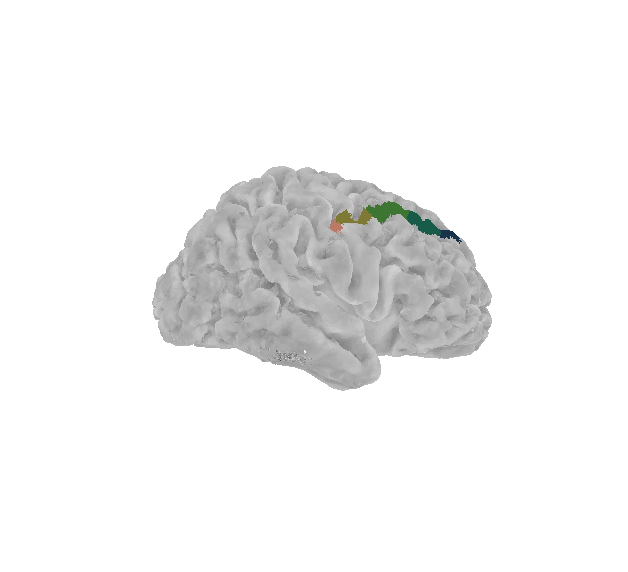

In [34]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(border_path), cpal=colors[1:], 
                     bg_map=sulc, elev=180,azim=0, figsize=(11,10), darkness=0.8)
plot.savefig(border_plot%(num_path, radius, halfwidth, overlap, criterium))

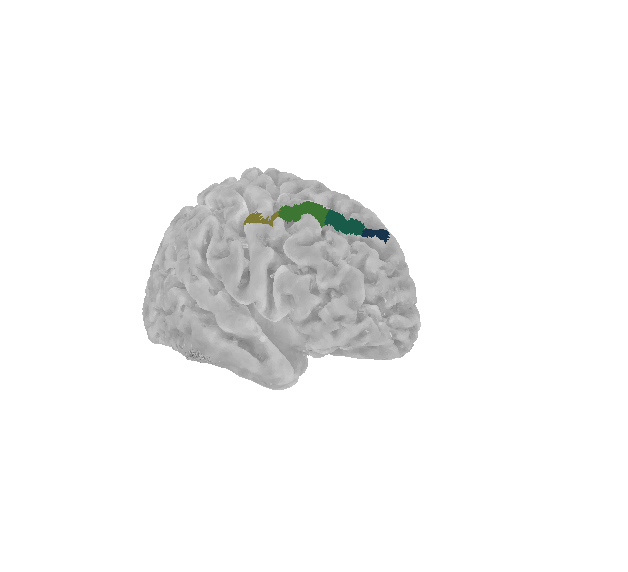

In [35]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(border_path), cpal=colors[1:], 
                     bg_map=sulc, elev=180,azim=-40, figsize=(11,10), darkness=0.8)
plot.savefig(border_plot_2%(num_path, radius, halfwidth, overlap, criterium))

In [36]:
criterium = 'relmax_t1avg_order5'
order = 5
borders = list(argrelmax(t1_avg_jsdis, order=order)[0])
borders.append(cheb_jsdis.shape[0])

border_path = []
last = 0
for b in borders:
    section = []
    for w in range(last, b+1):
        section += combined_windows[w]
        
    border_path.append(section)
    last = b+1
    
print borders

[27, 32]


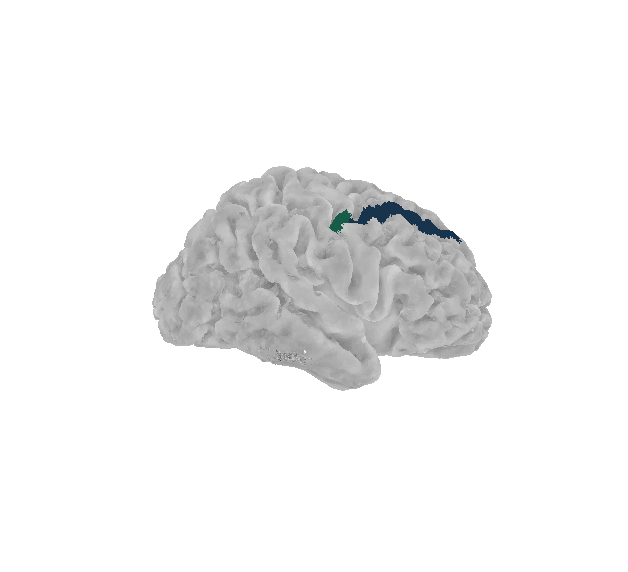

In [37]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(border_path), cpal=colors[1:], 
                     bg_map=sulc, elev=180,azim=0, figsize=(11,10), darkness=0.8)
plot.savefig(border_plot%(num_path, radius, halfwidth, overlap, criterium))

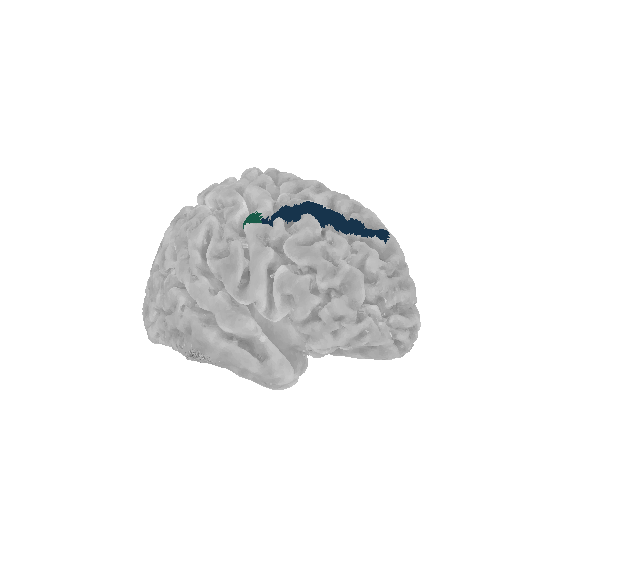

In [38]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(border_path), cpal=colors[1:], 
                     bg_map=sulc, elev=180,azim=-40, figsize=(11,10), darkness=0.8)
plot.savefig(border_plot_2%(num_path, radius, halfwidth, overlap, criterium))

In [39]:
criterium = 'relmax_cheb0_order5'
order = 5
borders = list(argrelmax(cheb_jsdis[:,0], order=order)[0])
borders.append(cheb_jsdis.shape[0])

border_path = []
last = 0
for b in borders:
    section = []
    for w in range(last, b+1):
        section += combined_windows[w]
        
    border_path.append(section)
    last = b+1
    
print borders

[10, 21, 29, 32]


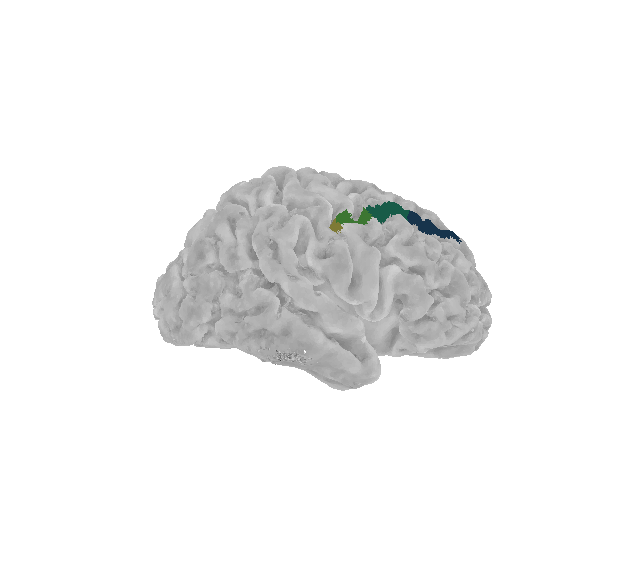

In [40]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(border_path), cpal=colors[1:], 
                     bg_map=sulc, elev=180,azim=0, figsize=(11,10), darkness=0.8)
plot.savefig(border_plot%(num_path, radius, halfwidth, overlap, criterium))

In [41]:
criterium = 'relmax_cheb1_order5'
order = 5
borders = list(argrelmax(cheb_jsdis[:,1], order=order)[0])
borders.append(cheb_jsdis.shape[0])

border_path = []
last = 0
for b in borders:
    section = []
    for w in range(last, b+1):
        section += combined_windows[w]
        
    border_path.append(section)
    last = b+1
    
print borders

[2, 13, 21, 32]


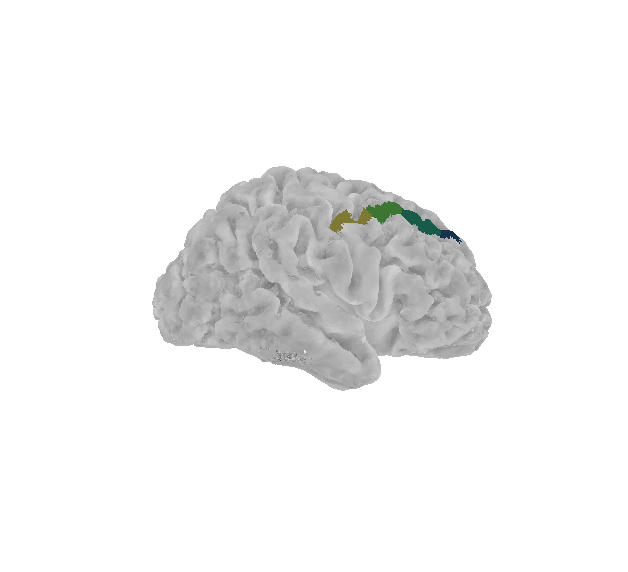

In [42]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(border_path), cpal=colors[1:], 
                     bg_map=sulc, elev=180,azim=0, figsize=(11,10), darkness=0.8)
plot.savefig(border_plot%(num_path, radius, halfwidth, overlap, criterium))

In [43]:
criterium = 'relmax_cheb2_order5'
order = 5
borders = list(argrelmax(cheb_jsdis[:,2], order=order)[0])
borders.append(cheb_jsdis.shape[0])

border_path = []
last = 0
for b in borders:
    section = []
    for w in range(last, b+1):
        section += combined_windows[w]
        
    border_path.append(section)
    last = b+1
    
print borders

[1, 10, 21, 30, 32]


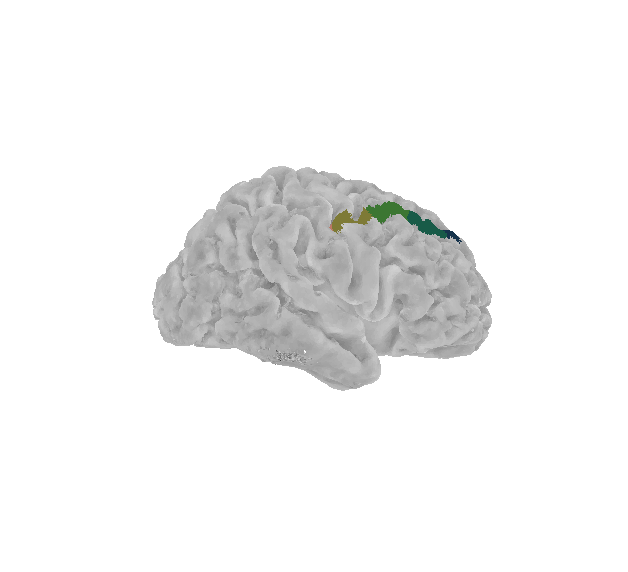

In [44]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(border_path), cpal=colors[1:], 
                     bg_map=sulc, elev=180,azim=0, figsize=(11,10), darkness=0.8)
plot.savefig(border_plot%(num_path, radius, halfwidth, overlap, criterium))

In [45]:
criterium = 'relmax_cheb3_order5'
order = 5
borders = list(argrelmax(cheb_jsdis[:,3], order=order)[0])
borders.append(cheb_jsdis.shape[0])

border_path = []
last = 0
for b in borders:
    section = []
    for w in range(last, b+1):
        section += combined_windows[w]
        
    border_path.append(section)
    last = b+1
    
print borders

[1, 18, 32]


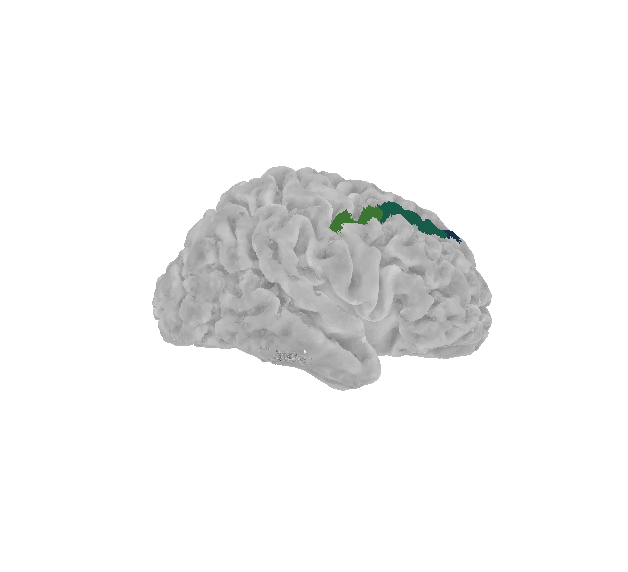

In [46]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(border_path), cpal=colors[1:], 
                     bg_map=sulc, elev=180,azim=0, figsize=(11,10), darkness=0.8)
plot.savefig(border_plot%(num_path, radius, halfwidth, overlap, criterium))

In [47]:
criterium = 'relmax_cheb4_order5'
order = 5
borders = list(argrelmax(cheb_jsdis[:,4], order=order)[0])
borders.append(cheb_jsdis.shape[0])

border_path = []
last = 0
for b in borders:
    section = []
    for w in range(last, b+1):
        section += combined_windows[w]
        
    border_path.append(section)
    last = b+1
    
print borders

[7, 18, 32]


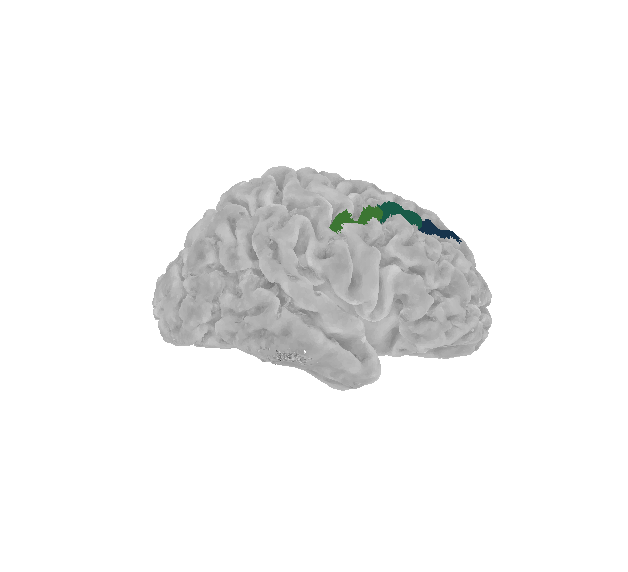

In [48]:
sns.set_style('white')
plot=plot_surf_label(vertices, faces, labels=tuple(border_path), cpal=colors[1:], 
                     bg_map=sulc, elev=180,azim=0, figsize=(11,10), darkness=0.8)
plot.savefig(border_plot%(num_path, radius, halfwidth, overlap, criterium))

In [59]:
order = 5
borders = list(argrelmax(np.nan_to_num(t1_avg_jsdis), order=order)[0])
borders.append(cheb_jsdis.shape[0])

border_path = []
last = 0
for b in borders:
    section = []
    for w in range(last, b+1):
        section += combined_windows[w]
        
    border_path.append(section)
    last = b+1
    
print borders

[1, 9, 16, 27, 32]


In [56]:
order = 5
borders = list(argrelmax(np.nanmax(cheb_jsdis, axis=1), order=order)[0])
borders.append(cheb_jsdis.shape[0])

border_path = []
last = 0
for b in borders:
    section = []
    for w in range(last, b+1):
        section += combined_windows[w]
        
    border_path.append(section)
    last = b+1
    
print borders

[2, 10, 21, 29, 32]
